# Gradient of Cost on a Batch of Data


In this notebook, we expand on the partial derivative calculus of the [*Single Point Regression Gradient* notebook](https://github.com/jonkrohn/ML-foundations/blob/master/notebooks/single-point-regression-gradient.ipynb) to: 

* Calculate the gradient of mean squared error on a batch of data
* Visualize gradient descent in action

In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
xs = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7.]) # eg: doseage of a drug for Alzheimers disease
xs

tensor([0., 1., 2., 3., 4., 5., 6., 7.])

In [3]:
ys = torch.tensor([1.86, 1.31, .62, .33, .09, -.67, -1.23, -1.37]) # E.g.: Patient's "forgetfulness score"
ys

tensor([ 1.8600,  1.3100,  0.6200,  0.3300,  0.0900, -0.6700, -1.2300, -1.3700])

The slope of a line is given by equation $y = mx + b$:


In [4]:
def regression(my_x, my_m, my_b):
    return my_m * my_x + my_b

In [5]:
m = torch.tensor([0.9]).requires_grad_()
b = torch.tensor([0.1]).requires_grad_()

**Step 1:** Forward pass

In [6]:
yhats = regression(xs, m, b)
yhats

tensor([0.1000, 1.0000, 1.9000, 2.8000, 3.7000, 4.6000, 5.5000, 6.4000],
       grad_fn=<AddBackward0>)

**Step 2:** Compare $\hat y$ with true $y$ to calculate cost $C$

As in the [*Regression in PyTorch* notebook](https://github.com/jonkrohn/ML-foundations/blob/master/notebooks/regression-in-pytorch.ipynb), let's use mean squared error, which averages quadratic cost across multiple data points: 

$C = \frac{1}{n} \sum_{i=1}^n (\hat{y_i}-y_i)^2 $

In [7]:
def mean_squared_error(yhat, my_y):
    sigma = torch.sum((yhat - my_y)**2)
    return sigma / len(my_y)

In [8]:
C = mean_squared_error(yhats, ys)
C

tensor(19.6755, grad_fn=<DivBackward0>)

**Step 3:** Use autodiff to calculate gradient of $C$ w.r.t. parameters

In [9]:
C.backward() # backward pass - autodiff

In [10]:
m.grad

tensor([36.3050])

In [11]:
b.grad

tensor([6.2650])

From the notes here we derive $\frac{\partial C}{\partial m}$ and $\frac{\partial C}{\partial b}$

$\frac{\partial C}{\partial m} = \frac{2}{n} \Sigma(\hat y_i - y_i) . x_i$ 

$\frac{\partial C}{\partial b} = \frac{2}{n} \Sigma(\hat y_i - y_i)$ 

In [12]:
#  for del c / del m
2 * 1/len(ys) * torch.sum((yhats - ys) * xs)

tensor(36.3050, grad_fn=<MulBackward0>)

In [13]:
# for del c / del b
2 * 1/len(ys) * torch.sum(yhats - ys)

tensor(6.2650, grad_fn=<MulBackward0>)

We don't need to explicitly create a standalone $\nabla C$ object (Greek inverted delta is called *nabla* for "harp" but w.r.t. gradient is *del* as in "del C") for the remainder of the code in this notebook to run, but let's create it for fun now anyway and we'll make use of it in a later, related notebook: 

In [14]:
gradient = torch.tensor([[b.grad.item(),m.grad.item()]]).T
gradient

tensor([[ 6.2650],
        [36.3050]])

Let us visualize the most pertinent metrics in a single plot

In [15]:
def labeled_regression_plot(my_x, my_y, my_m, my_b, my_C, include_grad=True):
    title = f'Cost = {my_C.item():.3g}'
    if include_grad:
        xlabel = f'm = {my_m.item():.3g}, m grad = {my_m.grad.item():.3g}'
        ylabel = f'b = {my_b.item():.3g}, b grad = {my_b.grad.item():.3g}'
    else:
        xlabel = f'm = {my_m.item():.3g}'
        ylabel = f'b = {my_b.item():.3g}'

    my_m = my_m.detach().numpy()
    my_b = my_b.detach().numpy()

    fig, ax = plt.subplots()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    ax.scatter(my_x, my_y)

    x_min, x_max = ax.get_xlim()

    y_min = regression(x_min, my_m, my_b)
    y_max = regression(x_max, my_m, my_b)

    ax.set_xlim([x_min, x_max])
    _ = ax.plot([x_min, x_max], [y_min, y_max], c='r')
    

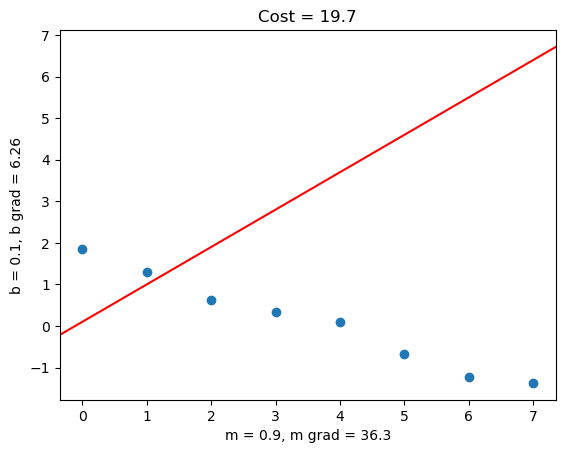

In [16]:
labeled_regression_plot(xs, ys, m, b, C)

**Step 4**: Gradient descent

$\frac{\partial C}{\partial m} = 36.3$ indicates that an increase in $m$ corresponds to a large increase in $C$. 

Meanwhile, $\frac{\partial C}{\partial b} = 6.26$ indicates that an increase in $b$ also corresponds to an increase in $C$, though much less so than $m$.

In the first round of training, the lowest hanging fruit with respect to reducing cost $C$ is therefore to decrease the slope of the regression line, $m$. There will also be a relatively small decrease in the $y$-intercept of the line, $b$. 

In [17]:
optimizer = torch.optim.SGD([m, b], lr=0.01)

In [18]:
optimizer.step()

In [19]:
C = mean_squared_error(regression(xs, m, b), ys)
C

tensor(8.5722, grad_fn=<DivBackward0>)

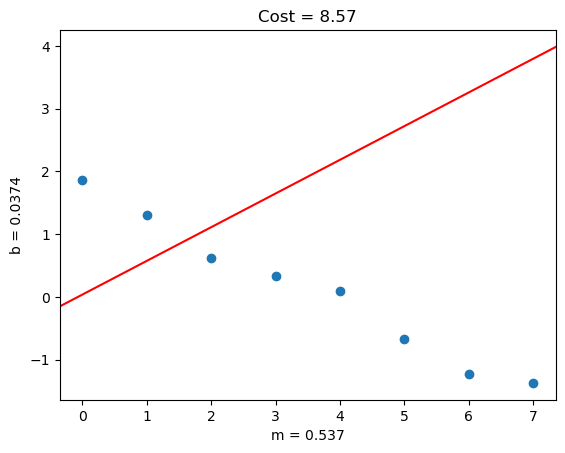

In [20]:
labeled_regression_plot(xs, ys, m, b, C, include_grad=False) # Gradient of C has not been re calculated

## Rinse and Repeat

Observe further rounds of training:

Epoch 0, Cost = 8.57, m grad = 23.2, b grad = 3.6
Epoch 1, Cost = 4.08, m grad = 14.8, b grad = 1.91
Epoch 2, Cost = 2.25, m grad = 9.49, b grad = 0.831
Epoch 3, Cost = 1.51, m grad = 6.11, b grad = 0.15
Epoch 4, Cost = 1.2, m grad = 3.96, b grad = -0.28
Epoch 5, Cost = 1.07, m grad = 2.59, b grad = -0.552
Epoch 6, Cost = 1.01, m grad = 1.72, b grad = -0.723
Epoch 7, Cost = 0.981, m grad = 1.17, b grad = -0.829


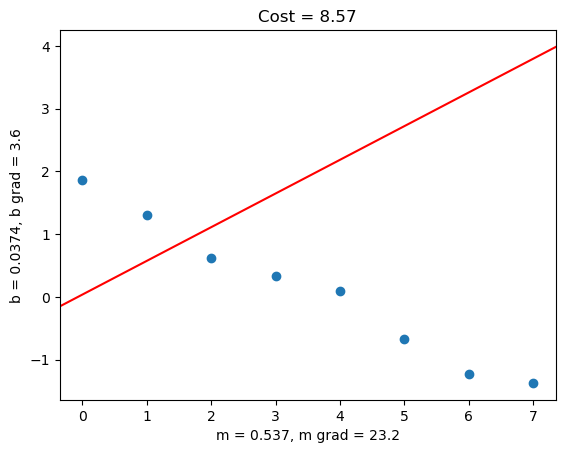

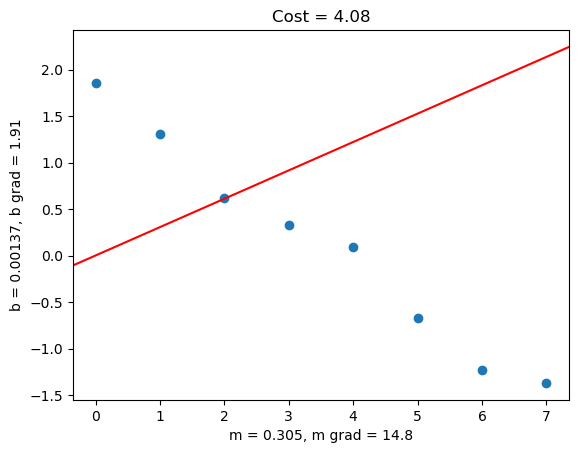

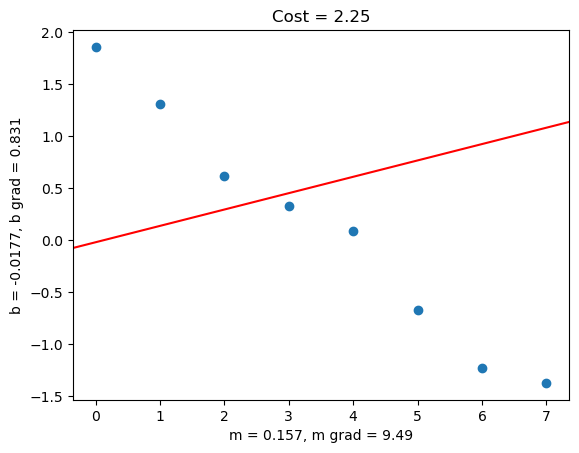

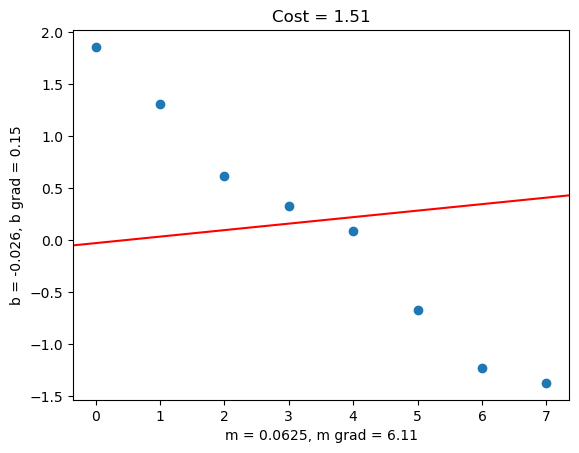

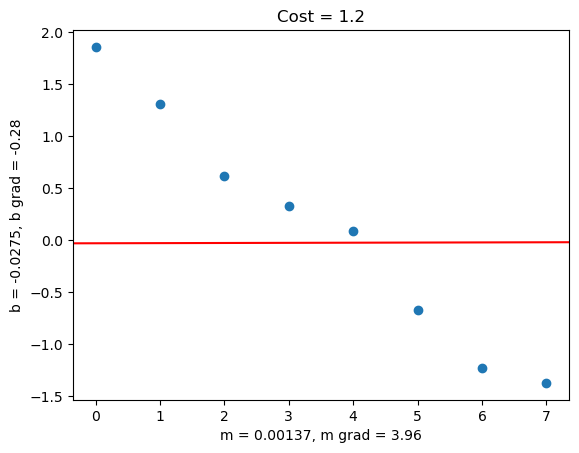

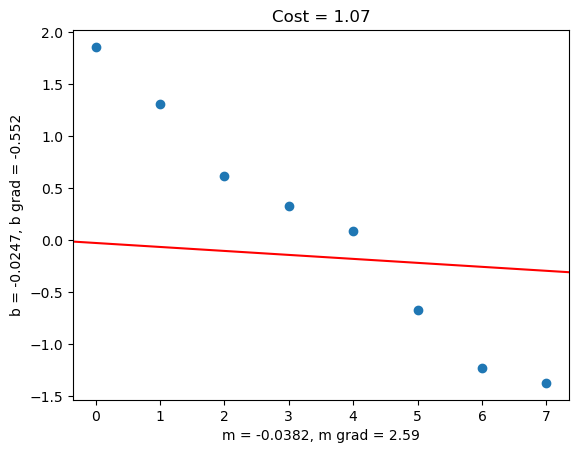

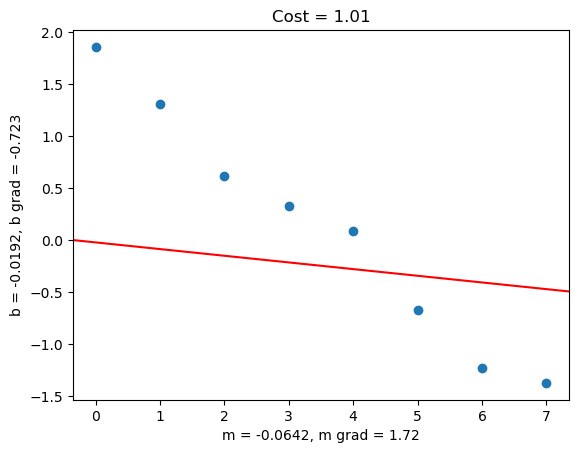

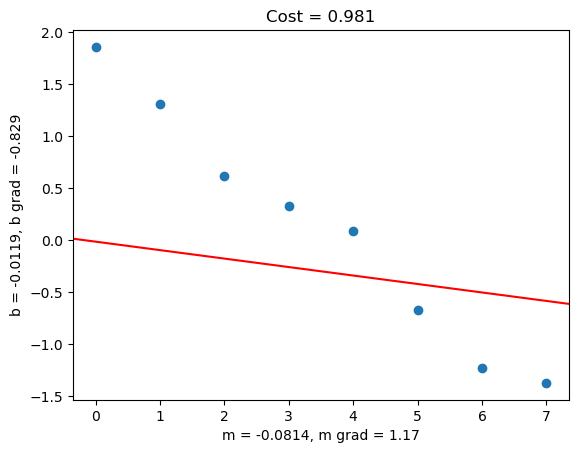

In [21]:
epochs = 8

for epoch in range(epochs):
    optimizer.zero_grad() #reset gradients to zero; else they will accumulate

    yhat = regression(xs, m, b) # step 1: make predictions
    C = mean_squared_error(yhat, ys) # step 2: compute cost (forward pass)
    C.backward() # step 3: compute gradients - autodiff (backword pass)

    labeled_regression_plot(xs, ys, m, b, C)
    optimizer.step() # step 4: update parameters

    print(f"Epoch {epoch:.3g}, Cost = {C.item():.3g}, m grad = {m.grad.item():.3g}, b grad = {b.grad.item():.3g}")

In later rounds of training, after the model's slope $m$ has become closer to the slope represented by the data, $\frac{\partial C}{\partial b}$ becomes negative, indicating an inverse relationship between $b$ and $C$. Meanwhile, $\frac{\partial C}{\partial m}$ remains positive. 

This combination directs gradient descent to simultaneously adjust the $y$-intercept $b$ upwards and the slope $m$ downwards in order to reduce cost $C$ and, ultimately, fit the regression line snugly to the data. 